### Individual ACS Data

[Documentation](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2015-2019.pdf)

###### Importing Libraries

In [1]:
import os
import sys
sys.path[0] = os.path.join(os.path.abspath(''),'..')  # make sure we can import from our package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#from data_pipeline import fetch_census_data

In [3]:
#fetch_census_data.acs5_individual(force_api_call=True)

###### Importing Data

In [3]:
# loading individual acs data

acs_ind=pd.read_csv("../data/acs5_individual.csv").drop(
                        ['state'], axis=1)
acs_ind.head(5)

,Unnamed: 0,internet_access,broadband,family_income,hh_income,poverty,race,hispanic,pop_65,weight,employment,work_available,education,citizenship,public use microdata area
0,0,1,1,-60000,1000,8,1,1,0,47,1,5,16,4,3520
1,1,1,1,-60000,96000,501,2,1,0,29,1,5,22,1,3501
2,2,1,1,366000,366000,501,1,1,0,15,1,5,21,1,3420
3,3,1,1,366000,366000,501,6,1,0,13,1,5,21,1,3420
4,4,1,1,366000,366000,501,9,1,0,14,0,0,8,1,3420


##### Recoding Variables

Education

In [4]:
acs_ind.education.unique()

array([16, 22, 21,  8,  3,  0, 13, 19, 14, 10, 20, 23,  6, 11,  9, 18, 15,
       12,  7,  5, 17,  1,  2,  4, 24])

In [5]:
# collapse education to 1,2,3 (<=high school, some college, >=bachelors)

acs_ind.loc[(acs_ind.education <= 17),'education']=1
acs_ind.loc[(acs_ind.education == 18),'education']=2
acs_ind.loc[(acs_ind.education == 19),'education']=2
acs_ind.loc[(acs_ind.education == 20),'education']=2
acs_ind.loc[(acs_ind.education >= 21),'education']=3

In [6]:
acs_ind.education.unique()

array([1, 3, 2])

Citizenship/Foreign-born

In [7]:
# 1. Born in the U.S.
# 2. Born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas
# 3. Born abroad of American parent(s)
# 4. U.S. citizen by naturalization
# 5. Not a citizen of the U.S.

acs_ind.citizenship.unique()

array([4, 1, 5, 2, 3])

In [8]:
# 1

born_citizen_df = acs_ind[["Unnamed: 0","citizenship"]].rename(columns={
                        "citizenship": "born_citizen"})

In [9]:
born_citizen_df.loc[(born_citizen_df.born_citizen != 1),'born_citizen']=0
born_citizen_df.loc[(born_citizen_df.born_citizen == 1),'born_citizen']=1

In [10]:
# 5

non_citizen_df = acs_ind[["Unnamed: 0","citizenship"]].rename(columns={
                        "citizenship": "non_citizen"})

In [11]:
non_citizen_df.loc[(non_citizen_df.non_citizen != 5),'non_citizen']=0
non_citizen_df.loc[(non_citizen_df.non_citizen == 5),'non_citizen']=1

In [12]:
# 2,3,4

foreign_citizen_df = acs_ind[["Unnamed: 0","citizenship"]].rename(columns={
                        "citizenship": "foreign_citizen"})

In [13]:
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 1),'foreign_citizen']=0
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 2),'foreign_citizen']=1
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 3),'foreign_citizen']=1
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 4),'foreign_citizen']=1
foreign_citizen_df.loc[(foreign_citizen_df.foreign_citizen == 5),'foreign_citizen']=0

In [14]:
acs_ind=acs_ind.merge(born_citizen_df, on='Unnamed: 0'
                           ).merge(non_citizen_df, on='Unnamed: 0').merge(foreign_citizen_df, on='Unnamed: 0')

In [15]:
acs_ind.non_citizen.unique()

array([0, 1])

Employment

In [16]:
acs_ind.employment.unique()

array([1, 0, 6, 3, 2, 4])

In [17]:
# 0 = unemployed 
# 1 = employed 
# 2 = other 

#acs_ind.loc[(acs_ind.employment == 0),'employment']=2
#acs_ind.loc[(acs_ind.employment == 1),'employment']=1
#acs_ind.loc[(acs_ind.employment == 2),'employment']=1
#acs_ind.loc[(acs_ind.employment == 3),'employment']=0
#acs_ind.loc[(acs_ind.employment == 4),'employment']=1
#acs_ind.loc[(acs_ind.employment == 5),'employment']=1
#acs_ind.loc[(acs_ind.employment == 6),'employment']=2

In [18]:
#acs_ind.employment.unique()

In [19]:
acs_ind.work_available.unique()

array([5, 0, 1, 3, 2, 4])

In [20]:
#acs_ind = acs_ind[acs_ind['work_available'] < 5]

In [21]:
# 0 = not available for work
# 1 = available  

#acs_ind.loc[(acs_ind.work_available == 0),'work_available']=0
#acs_ind.loc[(acs_ind.work_available >= 2),'work_available']=1

In [22]:
#acs_ind.work_available.unique()

In [23]:
#if acs_ind[(acs_ind['employment'] == 0)] and acs_ind[(acs_ind['work_available'] == 1)]:

In [24]:
#acs_ind["unemployed"].unique()

Population 65+

In [25]:
acs_ind.pop_65.unique()

array([ 0,  1, -1,  2])

In [26]:
acs_ind = acs_ind[acs_ind['pop_65'] >= 0]

In [27]:
# 0 No person 65 and over
# 1 person 65 and over
# 2 or more persons 65 and over


acs_ind.loc[(acs_ind.pop_65 >= 1),'pop_65']=1

In [28]:
acs_ind.pop_65.unique()

array([0, 1])

Internet Access

In [29]:
acs_ind.internet_access.unique()

array([1, 3, 2])

In [30]:
# need to remove the responses with "0" because it means no response

acs_ind = acs_ind[acs_ind['internet_access'] >0]

In [31]:
# recoding internet access
# 0 = no access
# 1 = access 

acs_ind.loc[(acs_ind.internet_access == 2),'internet_access']=1
acs_ind.loc[(acs_ind.internet_access == 3),'internet_access']=0

Hispanic

In [32]:
# recoding hispanic
# 0 = not hispanic
# 1 = hispanic

acs_ind.loc[(acs_ind.hispanic == 1),'hispanic']=0
acs_ind.loc[(acs_ind.hispanic > 1),'hispanic']=1

In [33]:
acs_ind.hispanic.unique()

array([0, 1])

non-Hispanic White, Black, Asian Races

In [34]:
black_df = acs_ind[["Unnamed: 0","race","hispanic"]].rename(columns={
                        "race": "black"})

In [35]:
black_df.loc[(black_df.black != 2),'black']=0
black_df.loc[(black_df.black == 2),'black']=1

In [36]:
black_df.black.unique()

array([0, 1])

In [37]:
black_df["nh_black"]=black_df['hispanic']+black_df['black']

In [38]:
black_df.loc[(black_df.nh_black != 1),'nh_black']=0
black_df.loc[(black_df.nh_black == 1),'nh_black']=1

In [39]:
black_df.nh_black.unique()

array([0, 1])

In [40]:
black_df=black_df.drop(['hispanic'], axis=1)

In [41]:
white_df = acs_ind[["Unnamed: 0","race", "hispanic"]].rename(columns={
                        "race": "white"})

In [42]:
white_df.loc[(white_df.white != 1),'white']=1
white_df.loc[(white_df.white == 1),'white']=1

In [43]:
white_df.white.unique()

array([1])

In [44]:
white_df["nh_white"]=white_df['hispanic']+white_df['white']

In [45]:
white_df.loc[(white_df.nh_white != 1),'nh_white']=0
white_df.loc[(white_df.nh_white == 1),'nh_white']=1

In [46]:
white_df=white_df.drop(['hispanic'], axis=1)

In [47]:
asian_df = acs_ind[["Unnamed: 0","race", "hispanic"]].rename(columns={
                        "race": "asian"})

In [48]:
asian_df.loc[(asian_df.asian != 6),'asian']=0
asian_df.loc[(asian_df.asian == 6),'asian']=1

In [49]:
asian_df.asian.unique()

array([0, 1])

In [50]:
asian_df["nh_asian"]=asian_df['hispanic']+asian_df['asian']

In [51]:
asian_df.loc[(asian_df.nh_asian != 1),'nh_asian']=0
asian_df.loc[(asian_df.nh_asian == 1),'nh_asian']=1

In [52]:
asian_df=asian_df.drop(['hispanic'], axis=1)

In [53]:
acs_ind=acs_ind.merge(white_df, on='Unnamed: 0'
                           ).merge(black_df, on='Unnamed: 0').merge(asian_df, on='Unnamed: 0')

Household & Family Income

In [54]:
acs_ind.family_income.unique()

array([ -60000,  366000,  385000, ...,  211900, 1033000,  315300])

In [55]:
acs_ind.family_income.min()

-60000

In [56]:
acs_ind.hh_income.unique()

array([   1000,   96000,  366000, ..., 1033000,  315300,   68380])

In [57]:
acs_ind.hh_income.min()

-9500

In [58]:
# keeping incomes above 0 

acs_ind = acs_ind[acs_ind['hh_income'] >0]
acs_ind = acs_ind[acs_ind['family_income'] >0]

In [59]:
# log incomes

acs_ind["log_family_income"]=acs_ind["family_income"].apply(lambda x: np.log(x))
acs_ind["log_hh_income"]=acs_ind["hh_income"].apply(lambda x: np.log(x))

In [60]:
acs_ind.log_family_income.unique()

array([12.81038861, 12.86099861, 11.17759258, ..., 12.26386974,
       13.84797775, 12.66127985])

In [61]:
acs_ind.log_family_income.min()

0.0

In [62]:
acs_ind.log_hh_income.unique()

array([12.81038861, 12.86099861, 11.17759258, ..., 12.26386974,
       13.84797775, 12.66127985])

In [63]:
acs_ind.log_hh_income.min()

0.0

In [64]:
acs_ind.head(10)

,Unnamed: 0,internet_access,broadband,family_income,hh_income,poverty,race,hispanic,pop_65,weight,...,non_citizen,foreign_citizen,white,nh_white,black,nh_black,asian,nh_asian,log_family_income,log_hh_income
2,2,1,1,366000,366000,501,1,0,0,15,...,0,0,1,1,0,0,0,0,12.810389,12.810389
3,3,1,1,366000,366000,501,6,0,0,13,...,0,0,1,1,0,0,1,1,12.810389,12.810389
4,4,1,1,366000,366000,501,9,0,0,14,...,0,0,1,1,0,0,0,0,12.810389,12.810389
5,5,1,1,366000,366000,501,9,0,0,12,...,0,0,1,1,0,0,0,0,12.810389,12.810389
6,6,1,1,385000,385000,501,1,0,0,16,...,0,0,1,1,0,0,0,0,12.860999,12.860999
7,7,1,1,385000,385000,501,1,0,0,16,...,0,1,1,1,0,0,0,0,12.860999,12.860999
8,8,1,1,385000,385000,501,1,0,0,17,...,0,0,1,1,0,0,0,0,12.860999,12.860999
10,10,1,1,71510,71510,288,1,0,0,15,...,0,0,1,1,0,0,0,0,11.177593,11.177593
11,11,1,1,71510,71510,288,1,0,0,15,...,0,0,1,1,0,0,0,0,11.177593,11.177593
12,12,1,1,71510,71510,288,1,0,0,22,...,0,0,1,1,0,0,0,0,11.177593,11.177593


#### Visualizations

<AxesSubplot:xlabel='internet_access', ylabel='log_hh_income'>

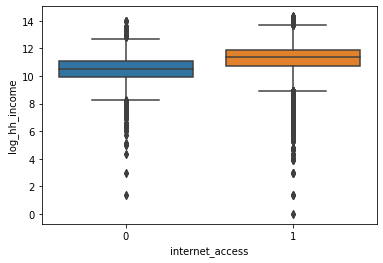

In [65]:
sns.boxplot(x="internet_access", y="log_hh_income", data=acs_ind)

<AxesSubplot:xlabel='internet_access', ylabel='log_family_income'>

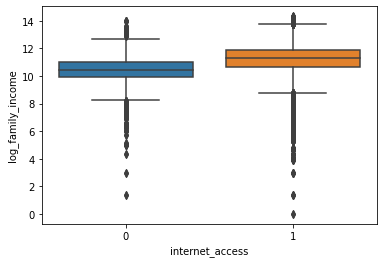

In [66]:
sns.boxplot(x="internet_access", y="log_family_income", data=acs_ind)

In [67]:
count_no_int = len(acs_ind[acs_ind['internet_access']==0])
count_int = len(acs_ind[acs_ind['internet_access']==1])
pct_of_int = count_int/(count_no_int+count_int)
print("percentage with internet access is", pct_of_int*100)
pct_of_no_int = count_no_int/(count_no_int+count_int)
print("percentage with no internet access", pct_of_no_int*100)

percentage with internet access is 91.8771715654052
percentage with no internet access 8.122828434594798


##### List of variables that may impact internet access

- household income
- family income
- race
- hispanic
- poverty to income ratio 

### Correlation 

<AxesSubplot:>

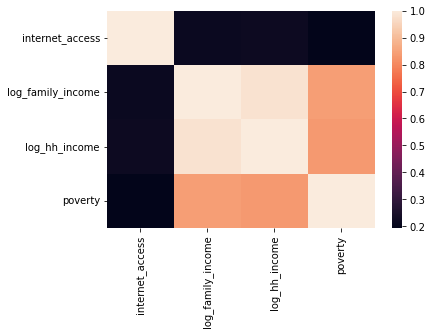

In [68]:
sns.heatmap(
    acs_ind[['internet_access','log_family_income','log_hh_income','poverty']]
    .corr())

<AxesSubplot:>

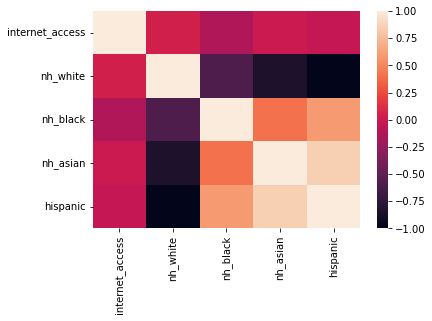

In [69]:
sns.heatmap(
    acs_ind[['internet_access','nh_white','nh_black','nh_asian','hispanic']]
    .corr())

<AxesSubplot:>

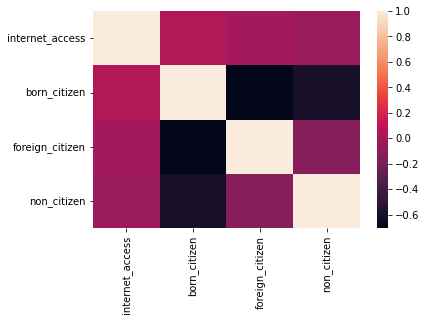

In [70]:
sns.heatmap(
    acs_ind[['internet_access','born_citizen','foreign_citizen','non_citizen']]
    .corr())

<AxesSubplot:>

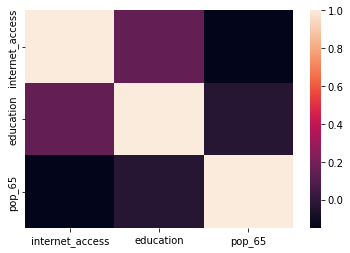

In [71]:
sns.heatmap(
    acs_ind[['internet_access','education','pop_65']]
    .corr())

### Logistic Regression

In [72]:
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import logit

In [108]:
cols_to_norm = ['log_hh_income','education']


In [109]:
acs_ind[cols_to_norm] = acs_ind[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [111]:
acs_ind.education

2         1.0
3         1.0
4         0.0
5         0.0
6         1.0
         ... 
114613    0.0
114614    0.0
114615    0.0
114616    0.5
114617    0.0
Name: education, Length: 85192, dtype: float64

#### Full Model with All Variables

In [112]:
# using all variables in full logit model

formula=("internet_access ~ log_hh_income + hispanic + nh_asian + nh_black + education + pop_65 + born_citizen + non_citizen")

model=logit(formula=formula, data=acs_ind).fit()

Optimization terminated successfully.
         Current function value: 0.240627
         Iterations 8


In [113]:
#normalize all the features (0,1) income + education 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        internet_access   No. Observations:                85192
Model:                          Logit   Df Residuals:                    85183
Method:                           MLE   Df Model:                            8
Date:                Mon, 14 Mar 2022   Pseudo R-squ.:                  0.1460
Time:                        12:56:09   Log-Likelihood:                -20499.
converged:                       True   LL-Null:                       -24004.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.4797      0.141    -24.635      0.000      -3.757      -3.203
log_hh_income     7.9771      0.179     44.615      0.000       7.627       8.327
hispanic         -0.3620      0.080     -4.530      0.000      -0.519      -0.205
nh_asian          0.7494      0.076      9.923      0.000       0.601       0.897
nh_black         -0.6081      0.037    -16.443      0.000      -0.681      -0.536
education         1.1144      0.044     25.125      0.000       1.028       1.201
pop_65           -1.1429      0.028    -41.246      0.000      -1.197      -1.089
born_citizen      0.3390      0.042      8.152      0.000       0.257       0.420
non_citizen      -0.3282      0.049     -6.634      0.000      -0.425      -0.231
=================================================================================
"""

#### Group Models

Citizenship

In [ ]:
formula1=("internet_access ~ non_citizen + born_citizen")

In [ ]:
model1=logit(formula=formula1, data=acs_ind).fit()

In [ ]:
model1.summary()

Race

In [ ]:
formula2=("internet_access ~ hispanic + nh_black + nh_asian")

In [ ]:
model2=logit(formula=formula2, data=acs_ind).fit()

In [ ]:
model2.summary()

#### Income Individual Models

In [ ]:
formula_hh_income=("internet_access ~ log_hh_income")

model_hh_income=logit(formula=formula_hh_income, data=acs_ind).fit()

In [ ]:
model_hh_income.summary()

In [ ]:
formula_family_income=("internet_access ~ log_family_income")

model_family_income=logit(formula=formula_family_income, data=acs_ind).fit()

In [ ]:
model_family_income.summary()

In [ ]:
formula_poverty=("internet_access ~ poverty")

model_poverty=logit(formula=formula_poverty, data=acs_ind).fit()

In [ ]:
model_poverty.summary()

#### Race & Ethnicity Individual Models 

In [ ]:
formula_hispanic=("internet_access ~ hispanic")

model_hispanic=logit(formula=formula_hispanic, data=acs_ind).fit()

In [ ]:
model_hispanic.summary()

In [ ]:
formula_nh_white=("internet_access ~ nh_white")

model_nh_white=logit(formula=formula_nh_white, data=acs_ind).fit()

In [ ]:
model_nh_white.summary()

In [ ]:
formula_nh_black=("internet_access ~ nh_black")

model_nh_black=logit(formula=formula_nh_black, data=acs_ind).fit()

In [ ]:
model_nh_black.summary()

In [ ]:
formula_nh_asian=("internet_access ~ nh_asian")

model_nh_asian=logit(formula=formula_nh_asian, data=acs_ind).fit()

In [ ]:
model_nh_asian.summary()

#### Citizenship Individual Models

In [ ]:
formula_born_citizen=("internet_access ~ born_citizen")

model_born_citizen=logit(formula=formula_born_citizen, data=acs_ind).fit()

In [ ]:
model_born_citizen.summary()

In [ ]:
formula_non_citizen=("internet_access ~ non_citizen")

model_non_citizen=logit(formula=formula_non_citizen, data=acs_ind).fit()

In [ ]:
model_non_citizen.summary()

In [ ]:
formula_foreign_citizen=("internet_access ~ foreign_citizen")

model_foreign_citizen=logit(formula=formula_foreign_citizen, data=acs_ind).fit()

In [ ]:
model_foreign_citizen.summary()